# Grover Algorithm for Graph Coloring Problem

In this tutorial, we solve the problem of coloring an undirected graph so that adjacent vertices do not share the same color while satisfying the given constraints. As a toy example, we consider a four-coloring problem for the graph shown below.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from classiq import *

## Toy problem

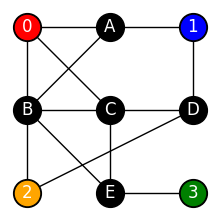

In [2]:
G = nx.Graph()

nodes = ["A", "B", "C", "D", "E", 0, 1, 2, 3]
G.add_nodes_from(nodes)

edges = [
    (0, "A"),
    (0, "B"),
    (0, "C"),
    ("A", "B"),
    ("A", 0),
    ("A", 1),
    ("B", "C"),
    ("B", "E"),
    ("B", 2),
    ("C", "D"),
    ("C", "E"),
    ("D", 1),
    ("D", 2),
    ("E", 3),
]
G.add_edges_from(edges)

pos = {
    "A": (0, 2),
    "B": (-1, 1),
    "C": (0, 1),
    "D": (1, 1),
    "E": (0, 0),
    0: (-1, 2),
    1: (1, 2),
    2: (-1, 0),
    3: (1, 0),
}


plt.figure(figsize=(2, 2))
nx.draw(G, pos, with_labels=True, node_size=400, node_color="black", font_color="white")
nx.draw_networkx_nodes(G, pos, nodelist=[0], node_color="red")
nx.draw_networkx_nodes(G, pos, nodelist=[1], node_color="blue")
nx.draw_networkx_nodes(G, pos, nodelist=[2], node_color="orange")
nx.draw_networkx_nodes(G, pos, nodelist=[3], node_color="green")
plt.show()

## Grover algorithm

We assign `red`, `blue`, `orange`, and `green` to the unassigned black nodes above under the given constraints. Here, in order to encode the colors in a program, we replace them with integers: 
- red = 0, 
- blue = 1, 
- orange = 2, 
- green = 3. 

Therefore, representing a color requires at most two qubits. We assign two qubits to each node as follows.


In [3]:
class PredicateVars(QStruct):
    a: QNum[2, False, 0]
    b: QNum[2, False, 0]
    c: QNum[2, False, 0]
    d: QNum[2, False, 0]
    e: QNum[2, False, 0]

## oracle function 


Next, we construct the **oracle** that enforces the rule that no two adjacent nodes may share the same color.
This condition can be expressed using propositional logic.
Here, we denote the color of each node by a variable $a,b,c,d,e$, where each alphabet represents the node color.
For example, $a$ refers to the color of node A.

Let us first consider node A as a concrete example.
Node A is adjacent to three other nodes, so it must satisfy the following constraints:

$$
(a \ne \text{red}) \land (a \ne b) \land (a \ne \text{blue})
$$

In other words, node A must not be red or blue, and it must also have a different color from its neighbor B.

Now consider node B.
Since node B is connected to multiple nodes, it has the following constraints:

$$
(b \ne \text{red}) \land (b \ne c) \land (b \ne e) \land (b \ne \text{orange})
$$

Here, $\land$ denotes AND.
This means that B must not be red or orange, and it must also have a different color from its neighbors C and E.

By applying this idea to each node and summarizing their respective constraints,
we can express the oracle in Qmod as follows.


In [8]:
def oracle_function(a, b, c, d, e):
    return (
        (a != 0)
        & (a != 1)
        & (a != b)
        & (b != 0)
        & (b != c)
        & (b != e)
        & (b != 2)
        & (c != 0)
        & (c != d)
        & (c != e)
        & (d != 1)
        & (d != 2)
        & (e != 3)
    )


@qperm
def quantum_predicate(vars: Const[PredicateVars], res: QBit):
    res ^= oracle_function(vars.a, vars.b, vars.c, vars.d, vars.e)

## Bulding block of Grover 

In [9]:
@qfunc
def main(vars: Output[PredicateVars]):
    allocate(vars.size, vars)
    grover_search(
        reps=1,
        oracle=lambda vars: phase_oracle(quantum_predicate, vars),
        packed_vars=vars,
    )

In [10]:
write_qmod(main, "grover_graph_coloring")
constraints = Constraints(
    max_width=28,
)
qprog = synthesize(main, constraints=constraints)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/36pqQuXNlZoqHndl3XLrBzjlufP


In [15]:
result = execute(qprog).result_value()
result.dataframe

,vars.a,vars.b,vars.c,vars.d,vars.e,count,probability,bitstring
0,2,1,2,0,0,25,0.012207,0000100110
1,2,1,3,0,0,22,0.010742,0000110110
2,3,1,2,0,0,21,0.010254,0000100111
3,3,1,3,0,0,20,0.009766,0000110111
4,2,3,2,3,0,19,0.009277,0011101110
...,...,...,...,...,...,...,...,...
836,1,1,3,3,3,1,0.000488,1111110101
837,2,1,3,3,3,1,0.000488,1111110110
838,0,3,3,3,3,1,0.000488,1111111100
839,1,3,3,3,3,1,0.000488,1111111101


In [12]:
import numpy as np


def convert_color(int_val):
    if int_val == 0:
        return "red"
    elif int_val == 1:
        return "blue"
    elif int_val == 2:
        return "orange"
    elif int_val == 3:
        return "green"


NUM_SOLUTIONS = 16
NUM_VARIABLES = 5
solution_list = np.zeros((NUM_SOLUTIONS, NUM_VARIABLES), dtype=int)
for k in range(NUM_SOLUTIONS):
    parsed_result = result.parsed_counts[k].state["vars"]
    a, b, c, d, e = (
        int(parsed_result["a"]),
        int(parsed_result["b"]),
        int(parsed_result["c"]),
        int(parsed_result["d"]),
        int(parsed_result["e"]),
    )
    solution_list[k, 0] = a
    solution_list[k, 1] = b
    solution_list[k, 2] = c
    solution_list[k, 3] = d
    solution_list[k, 4] = e
    print(
        "a =",
        a,
        ", b =",
        b,
        ", c =",
        c,
        "d =",
        d,
        "e =",
        e,
        ":",
        oracle_function(a, b, c, d, e),
    )

a = 2 , b = 1 , c = 2 d = 0 e = 0 : True
a = 2 , b = 1 , c = 3 d = 0 e = 0 : True
a = 3 , b = 1 , c = 2 d = 0 e = 0 : True
a = 3 , b = 1 , c = 3 d = 0 e = 0 : True
a = 2 , b = 3 , c = 2 d = 3 e = 0 : True
a = 2 , b = 3 , c = 1 d = 3 e = 0 : True
a = 3 , b = 1 , c = 3 d = 0 e = 2 : True
a = 2 , b = 1 , c = 3 d = 0 e = 2 : True
a = 2 , b = 3 , c = 2 d = 3 e = 1 : True
a = 2 , b = 3 , c = 2 d = 0 e = 1 : True
a = 2 , b = 3 , c = 1 d = 3 e = 2 : True
a = 3 , b = 1 , c = 2 d = 3 e = 0 : True
a = 2 , b = 3 , c = 2 d = 0 e = 0 : True
a = 2 , b = 3 , c = 1 d = 0 e = 0 : True
a = 2 , b = 3 , c = 1 d = 0 e = 2 : True
a = 2 , b = 1 , c = 2 d = 3 e = 0 : True


## post processing

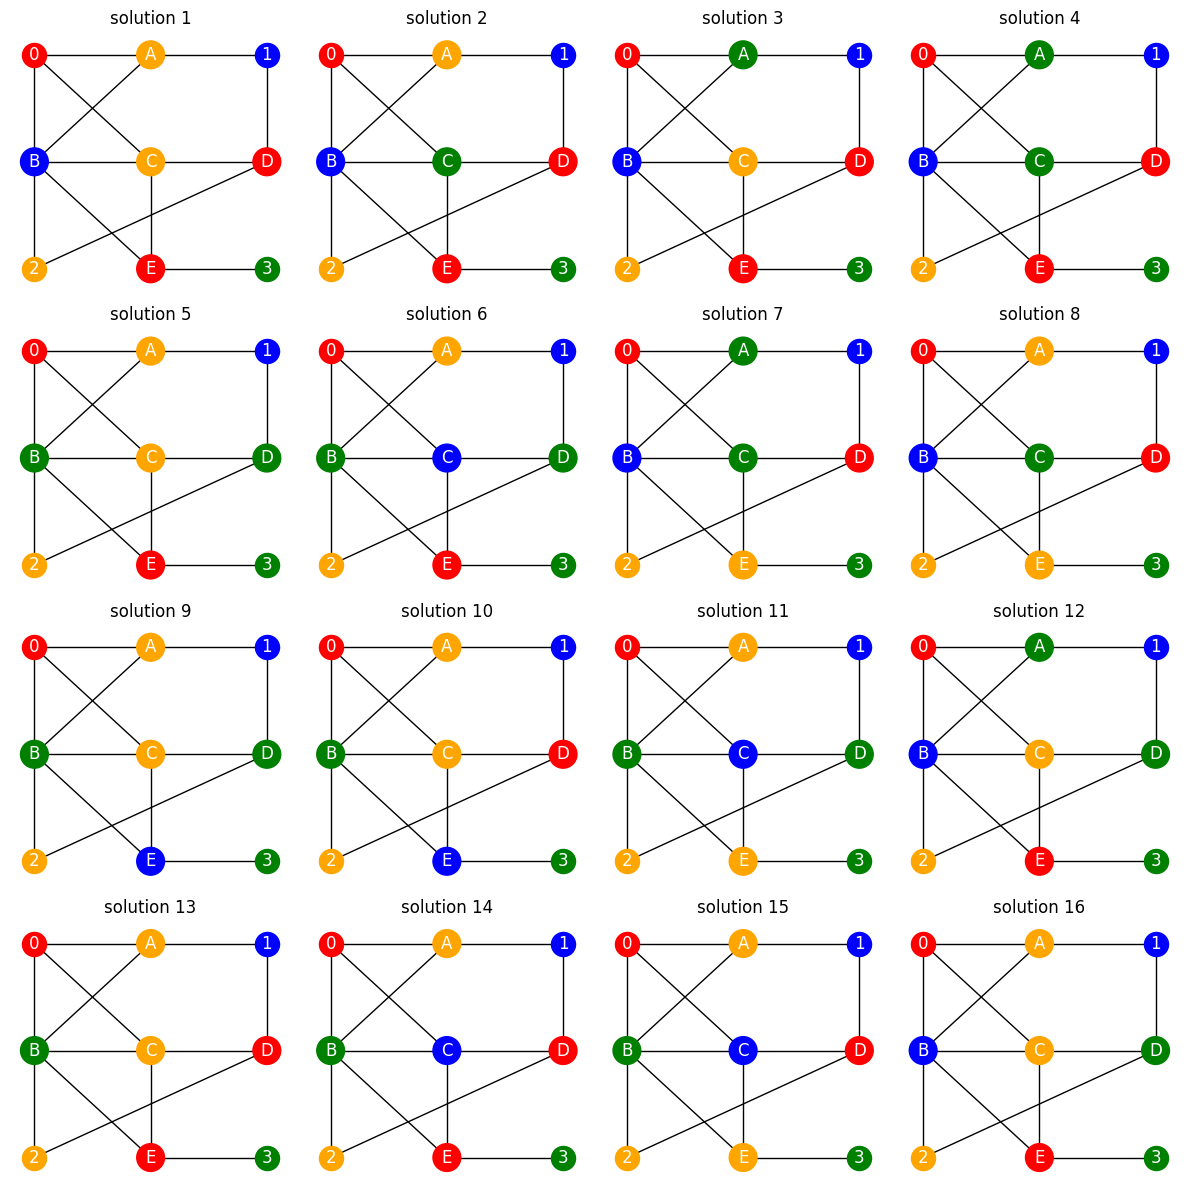

In [13]:
# gerate the graph of feasible soultions
graphs = []
for i in range(NUM_SOLUTIONS):
    graphs.append(G)


fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    nx.draw(
        G,
        pos,
        ax=ax,
        with_labels=True,
        node_size=400,
        nodelist=["A", "B", "C", "D", "E"],
        node_color=[
            convert_color(solution_list[i, 0]),
            convert_color(solution_list[i, 1]),
            convert_color(solution_list[i, 2]),
            convert_color(solution_list[i, 3]),
            convert_color(solution_list[i, 4]),
        ],
        font_color="white",
    )
    nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=[0], node_color="red")
    nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=[1], node_color="blue")
    nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=[2], node_color="orange")
    nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=[3], node_color="green")
    ax.set_title(f"solution {i+1}")

plt.tight_layout()
plt.show()